
# Семинар 8 - Алгоритмы анализа стереопар изображений

***

Полезные материалы:

- [First Principles of Computer Vision - Camera Calibration | Uncalibrated Stereo](https://youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&si=iXEBEehuQr-IgIVC) - плейлист с серией лекций по калибровке камеры и стереозрению
- [Simple Stereo | Camera Calibration](https://youtu.be/hUVyDabn1Mg?si=HmalQZKI9ytoyxPn) - лекция из плейлиста выше, в которой доступно раскрывается тема данного семинара

На этом семинаре будет разобрана тема стереозрения, которая заключается в применении нескольких видов камер для получения информации о глубине обзора. Используя стереозрение, можно определить местоположение точки в мире по ее изображениям в разных ракурсах камеры.

Термин охватывает многие приложения, работающие с несколькими видами отслеживаемого объекта под разными углами. Это могут быть стереокамеры, которые имеют несколько камер на одних и тех же устройствах, или разные виды с разных устройств.

1. **3D реконструкция с нескольких ракурсов**: знаем параметры калибровки каждой из камер, необходимо найти положение 3D объекта в мировых координатах.

2. **Оценка на основе движения (Structure From Motion)**: не знаем параметры калибровки, необходимо одновременно восстановить и координаты, и калибровку.

Первая задача проще в своей постановке, рассмотрим ее.

## Моно/Стерео зрение

_Источник изображений: https://github.com/polygon-software/python-visual-odometry_

![1_projection_and_stereo](data/1_projection_and_stereo.png)

**Идея:** можем найти пересечение лучей, исходящих из разных камер, и по параметрам камеры определить расстояние до объекта. Вы можете ощутить эффект стереовидения на основе своих глаз. Поставьте палец перед глазами. Закройте один глаз, потом другой глаз. Вы заметите, что пальцы, кажется, прыгают слева направо. Это наблюдаемое горизонтальное смещение называется диспаратностью (расхождением, disparity).

![3_stereo_cases](data/3_stereo_cases.png)

Рассмотрим более простой случай с выровненными (ректифицированными) камерами.

![4_stereo_vision_simple](data/4_stereo_vision_simple.png)

## Вопрос 1

Зная $f$ (фокальное расстояние камер), $b$ (расстояние между камерами), $u_l$, $u_r$, определить расстояние до объекта $Z_{p}$.

**Ответ:** $Z_p = \frac{fb}{u_{l}-u_{r}}$

## Расчет диспаратности с помощью OpenCV

In [1]:
# !wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png -O data/tsukuba_l.png
# !wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png -O data/tsukuba_r.png

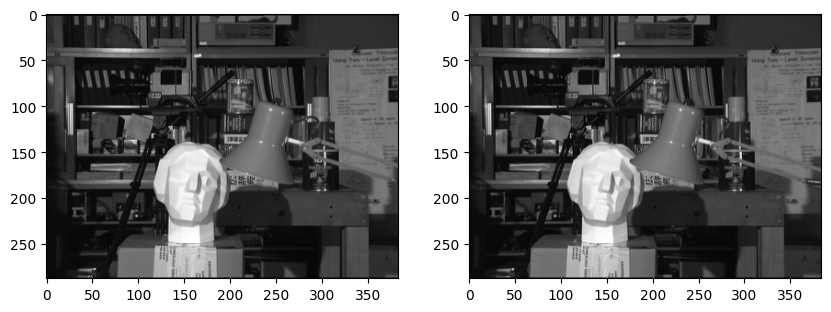

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('data/tsukuba_l.png',0)
imgR = cv2.imread('data/tsukuba_r.png',0)
# imgL = cv2.imread('/content/tsukuba_l.png',0)
# imgR = cv2.imread('/content/tsukuba_r.png',0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(imgL, cmap="gray")
ax[1].imshow(imgR, cmap="gray")

### cv2.StereoBM_create

https://docs.opencv.org/4.5.0/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004

Чем меньше `blockSize` - тем детальнее карта диспаратности, однако и количество шума растет.

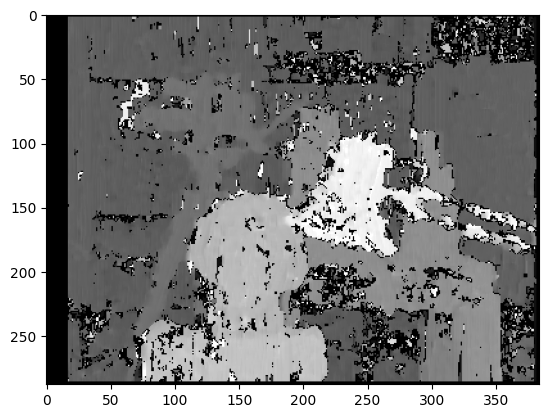

In [3]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=5,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

При слишком больших значениях `blockSize` шум отсутствует, однако детализация крайне низка:

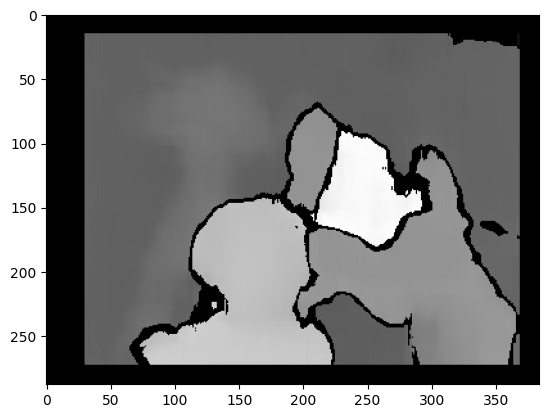

In [4]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=31,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

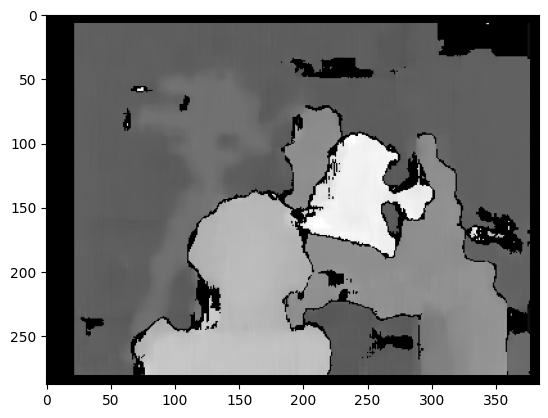

In [5]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=15,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

## Задание 1 - реализация алгоритма расчета диспаратности

Рассмотрим базовый жадный алгоритм наилучшего соответсвия (winner takes all, WTA) между изображениями с помощью блоков и метрики близости (sum of absolute difference, SAD).

![alg](data/alg.png)

**Заполните пропуски в коде**

In [6]:
def compare_blocks(
    block_left: np.array,
    block_right: np.array
) -> float:
    '''
    Takes blocks from left/right image
    and return similarity metric (for example, sum of absolute differences)
    '''

    metric = np.sum(abs(block_left - block_right))

    return metric


def get_disparity(
    imgL: np.array,  # (H, W) Grayscale
    imgR: np.array,  # (H, W) Grayscale
    numDisparities: int,  # the same in opencv
    blockSize: int,  # the same in opencv
) -> np.array:

    assert imgL.shape == imgR.shape, 'Images are not equal'

    H, W = imgL.shape
    disparity_map = np.zeros_like(imgL)  # (H, W)
    best_pixels = []

    for i in range(H - blockSize):
        for j in range(W - blockSize):

            # define base block to compare
            # using blockSize and i, j

            block_left = imgL[i:i+blockSize, j:j+blockSize]
            metrics = []

            for k in range(min(j+1, numDisparities)):

                # define secondary block to compare
                # using blockSize and i, j

                block_right = imgR[i:i+blockSize, j-k:j+blockSize-k]

                metrics.append(
                    compare_blocks(
                      block_left,
                      block_right
                    )
                )
            try:
                best_index = np.min(metrics)
            except ValueError:
                print("VErr")
                continue
            # convert index to disparity
            # and fill it in disparity_map

            disparity_map[i, j] = best_index
            best_pixels.append(best_index)

    return disparity_map, best_pixels

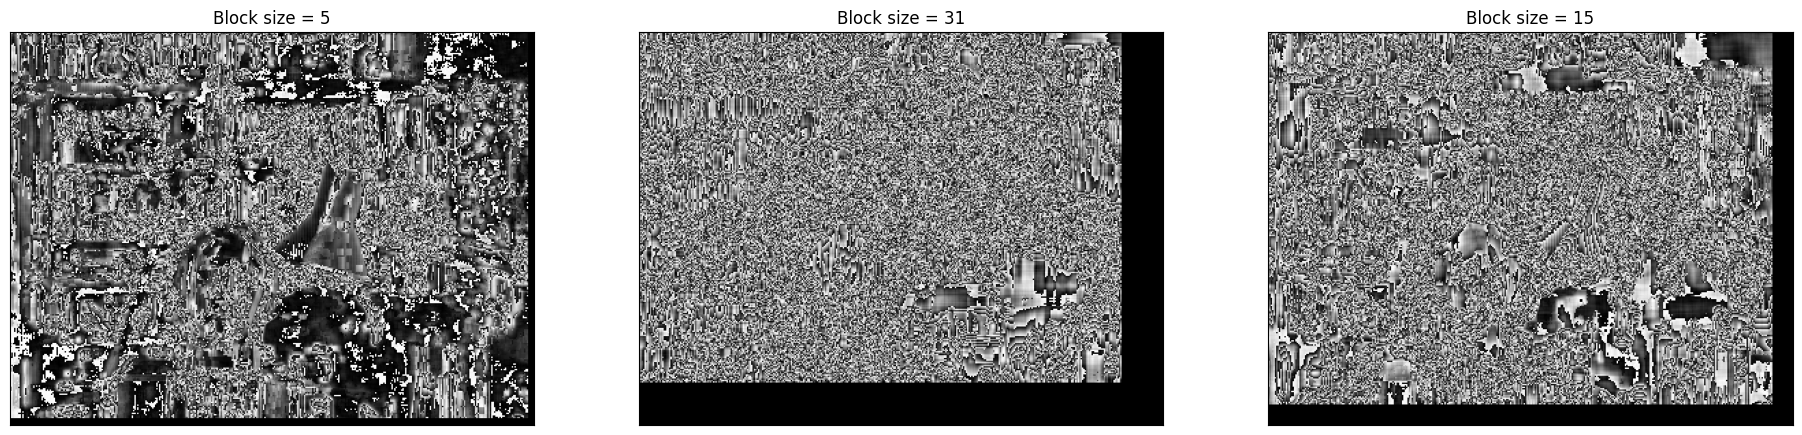

In [7]:
disparity_map_1, pixels_1 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=5
)
disparity_map_2, pixels_2 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=31
)
disparity_map_3, pixels_3 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=15
)

plt.figure(figsize=(23, 11))

plt.subplot(131)
plt.imshow(disparity_map_1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 5")

plt.subplot(132)
plt.imshow(disparity_map_2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 31")

plt.subplot(133)
plt.imshow(disparity_map_3, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 15")

plt.show();

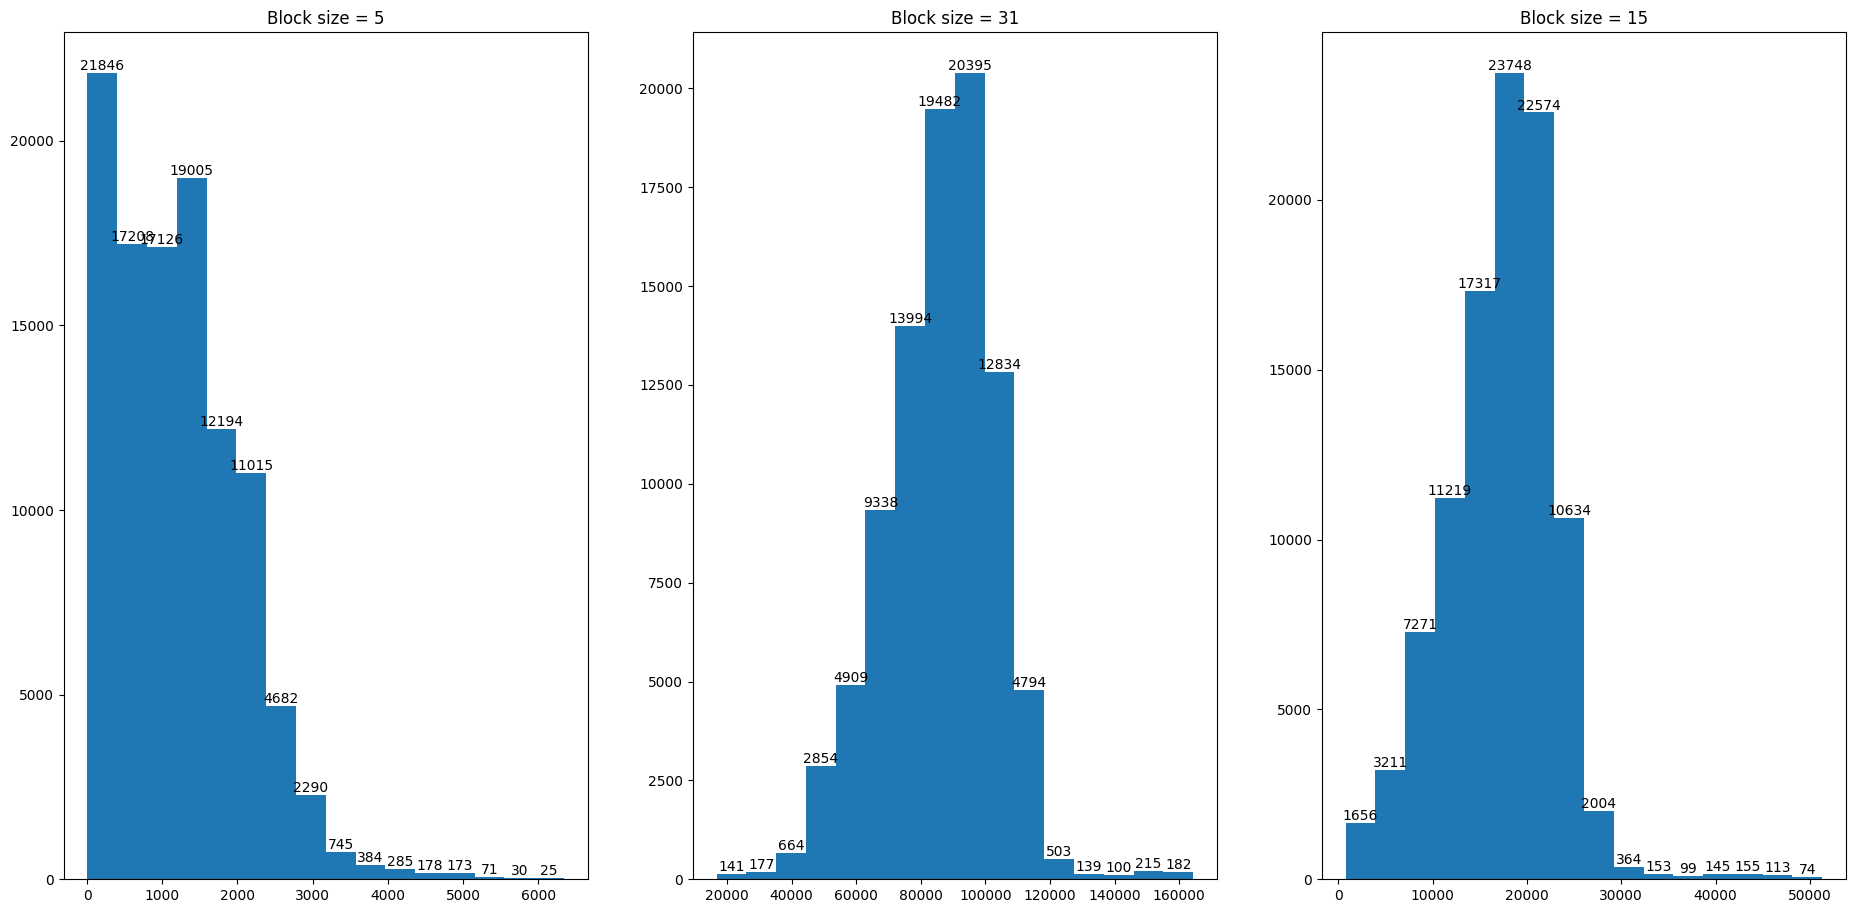

In [8]:
plt.figure(figsize=(23, 11))

plt.subplot(131)
counts, edges, bars = plt.hist(pixels_1, bins=16)
plt.bar_label(bars)
plt.title("Block size = 5")

plt.subplot(132)
counts, edges, bars = plt.hist(pixels_2, bins=16)
plt.bar_label(bars)
plt.title("Block size = 31")

plt.subplot(133)
counts, edges, bars = plt.hist(pixels_3, bins=16)
plt.bar_label(bars)
plt.title("Block size = 15")

plt.show();

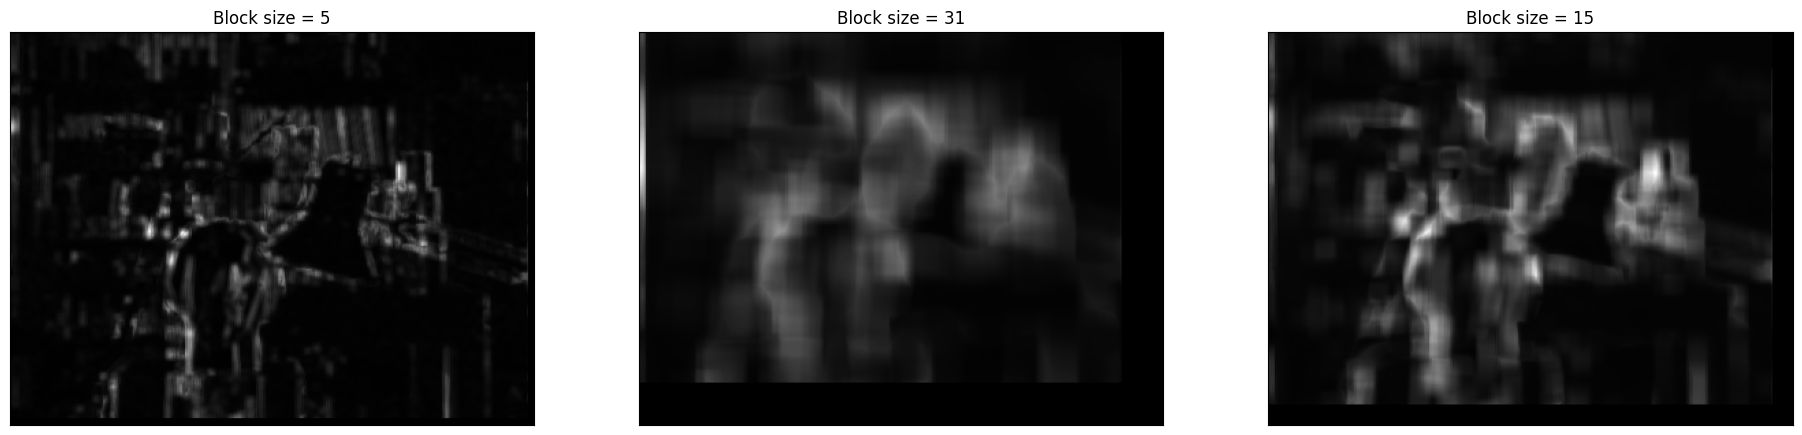

In [9]:
disparity_map_1, pixels_1 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=5
)
disparity_map_2, pixels_2 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=31
)
disparity_map_3, pixels_3 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=15
)

plt.figure(figsize=(23, 11))

plt.subplot(131)
plt.imshow(disparity_map_1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 5")

plt.subplot(132)
plt.imshow(disparity_map_2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 31")

plt.subplot(133)
plt.imshow(disparity_map_3, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 15")

plt.show();

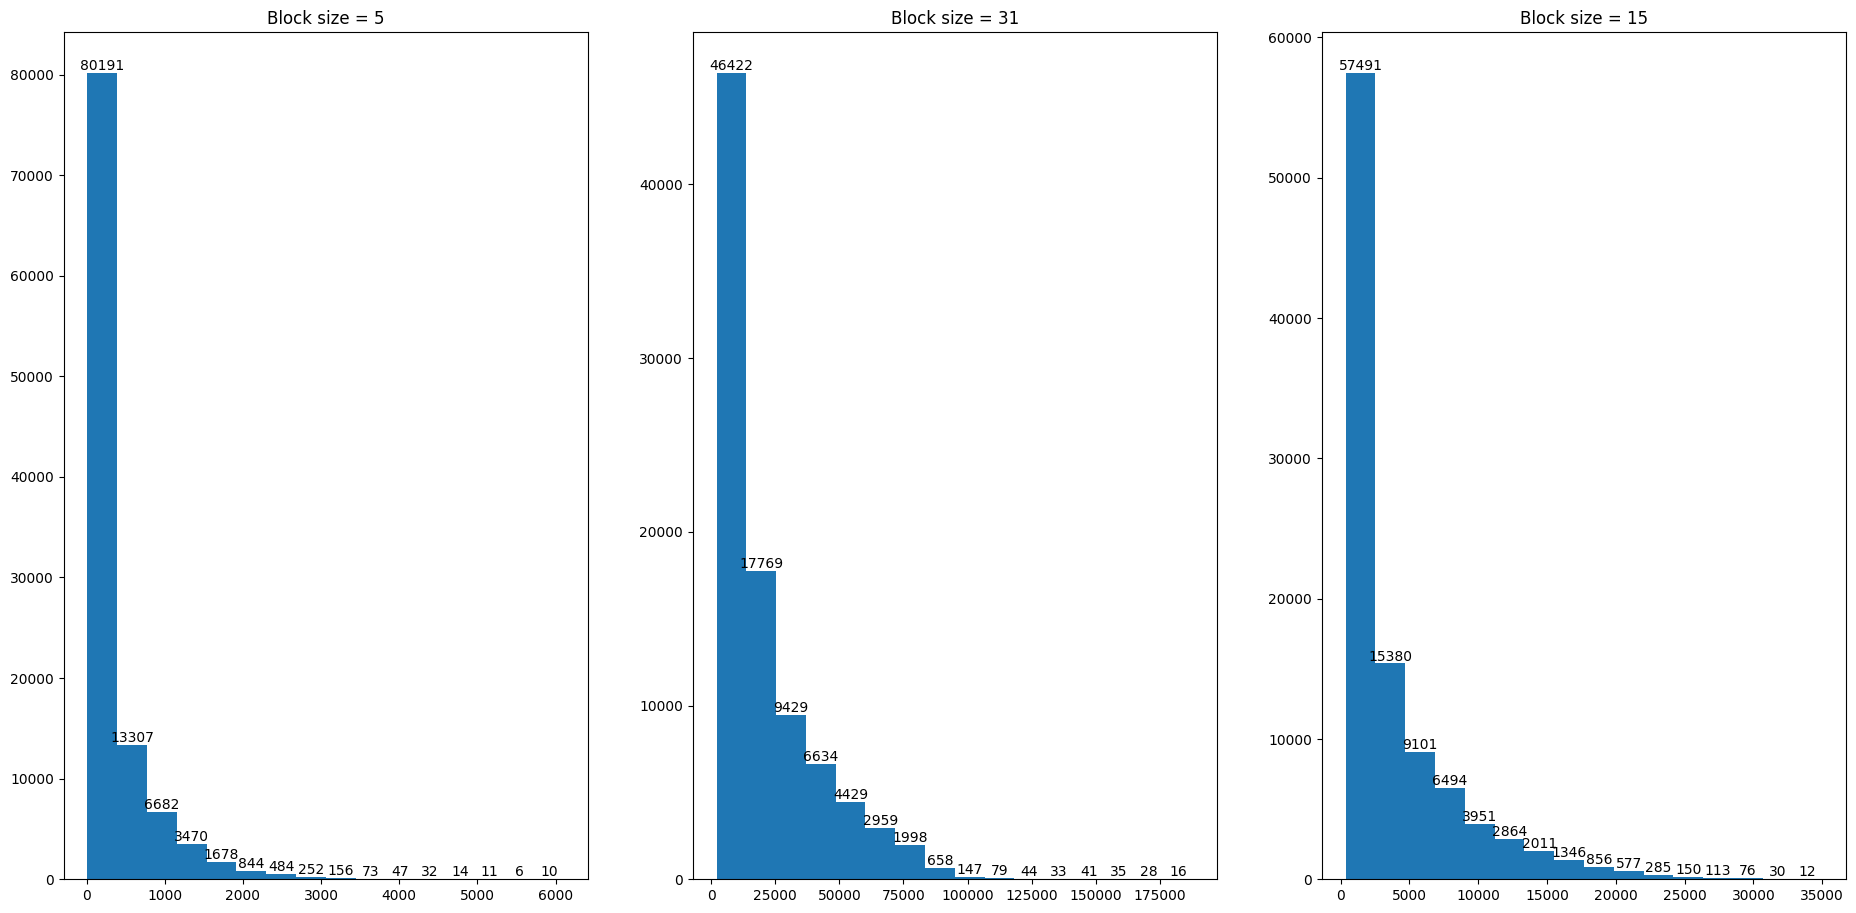

In [10]:
plt.figure(figsize=(23, 11))

plt.subplot(131)
counts, edges, bars = plt.hist(pixels_1, bins=16)
plt.bar_label(bars)
plt.title("Block size = 5")

plt.subplot(132)
counts, edges, bars = plt.hist(pixels_2, bins=16)
plt.bar_label(bars)
plt.title("Block size = 31")

plt.subplot(133)
counts, edges, bars = plt.hist(pixels_3, bins=16)
plt.bar_label(bars)
plt.title("Block size = 15")

plt.show();

## Вопрос 2

Заполняет ли алгоритм все пиксели глубины? Как можно улучшить его? (Например, рассмотрите вариант, когда `metrics.min()` выдает большое число, что делать в этом случае? Или предложите свою версию.)

**Ответ:** Видно, что не все из 16 бинов одинаково заполнены. Здесь стоит отметить распределение, которое без фильтра Собеля изменяется в зависимости от размера блока: при маленьком блоке оно экспоненциальное, а при среднем и большом размерах $-$ близкое к нормальному, но немного смещённому. Сами изображения весьма зашумлены и можно различить некоторые объекты лишь в случае маленького размера блока. В случае использования фильтра Собеля, распределение во всех случаях экспоненциальное и с увеличением размера блоков изображение размывается. Далее попоробуем улучшить алгоритм, введя норму Фробениуса в качестве метрики и будем брать `argmin(metrics)`, вместо `metrics.min()`.

### Улучшение

In [11]:
def compare_blocks(
    block_left: np.array,
    block_right: np.array,
    metric_type: str
) -> float:
    '''
    Takes blocks from left/right image
    and return similarity metric (for example, sum of absolute differences)
    '''
    if metric_type == "abs":
        metric = np.sum(abs(block_left - block_right))
    elif metric_type == "fro":
        metric = np.sqrt(np.sum((block_left - block_right)**2))
    else:
        raise ValueError("only abs and fro were implemented!")

    return metric


def get_disparity(
    imgL: np.array,  # (H, W) Grayscale
    imgR: np.array,  # (H, W) Grayscale
    numDisparities: int,  # the same in opencv
    blockSize: int,  # the same in opencv,
    metric_type: str
) -> np.array:

    assert imgL.shape == imgR.shape, 'Images are not equal'

    H, W = imgL.shape
    disparity_map = np.zeros_like(imgL)  # (H, W)
    best_pixels = []

    for i in range(H - blockSize):
        for j in range(W - blockSize):

            # define base block to compare
            # using blockSize and i, j

            block_left = imgL[i:i+blockSize, j:j+blockSize]
            metrics = []

            for k in range(min(j+1, numDisparities)):

                # define secondary block to compare
                # using blockSize and i, j

                block_right = imgR[i:i+blockSize, j-k:j+blockSize-k]

                metrics.append(
                    compare_blocks(
                      block_left,
                      block_right,
                      metric_type
                    )
                )
            try:
                best_index = np.argmin(metrics)
            except ValueError:
                print("VErr")
                continue
            # convert index to disparity
            # and fill it in disparity_map

            disparity_map[i, j] = best_index
            best_pixels.append(best_index)

    return disparity_map, best_pixels

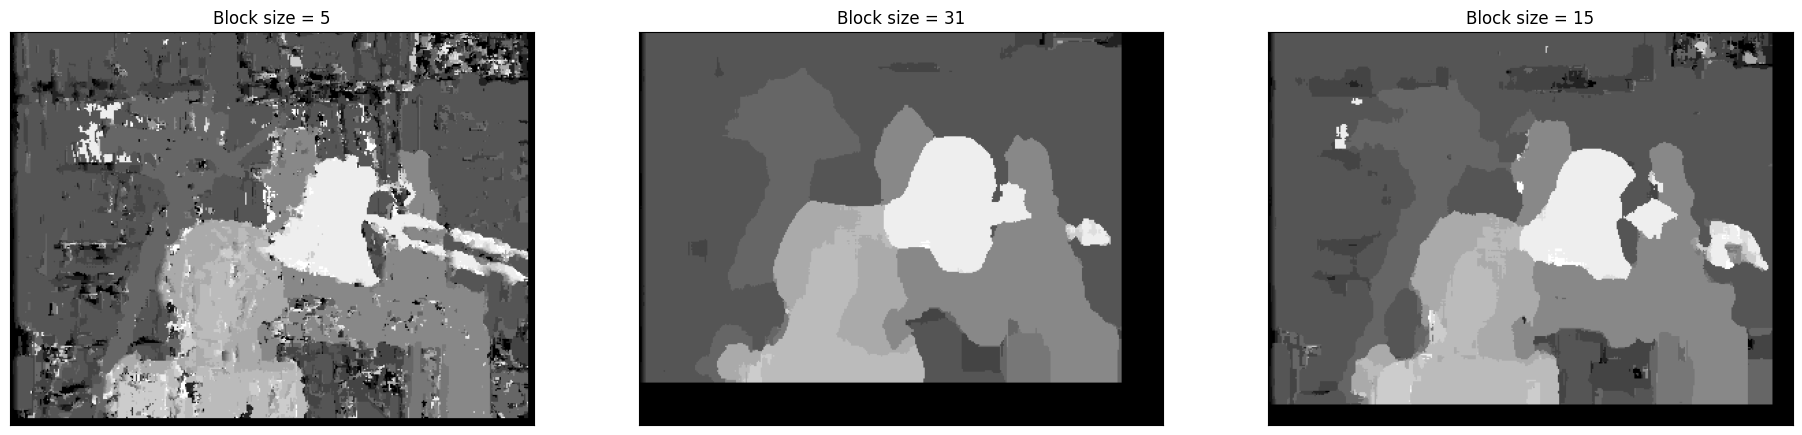

In [12]:
disparity_map_fro1, pixels_fro1 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=5, metric_type="fro"
)
disparity_map_fro2, pixels_fro2 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=31, metric_type="fro"
)
disparity_map_fro3, pixels_fro3 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=15, metric_type="fro"
)

plt.figure(figsize=(23, 11))

plt.subplot(131)
plt.imshow(disparity_map_fro1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 5")

plt.subplot(132)
plt.imshow(disparity_map_fro2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 31")

plt.subplot(133)
plt.imshow(disparity_map_fro3, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 15")

plt.show();

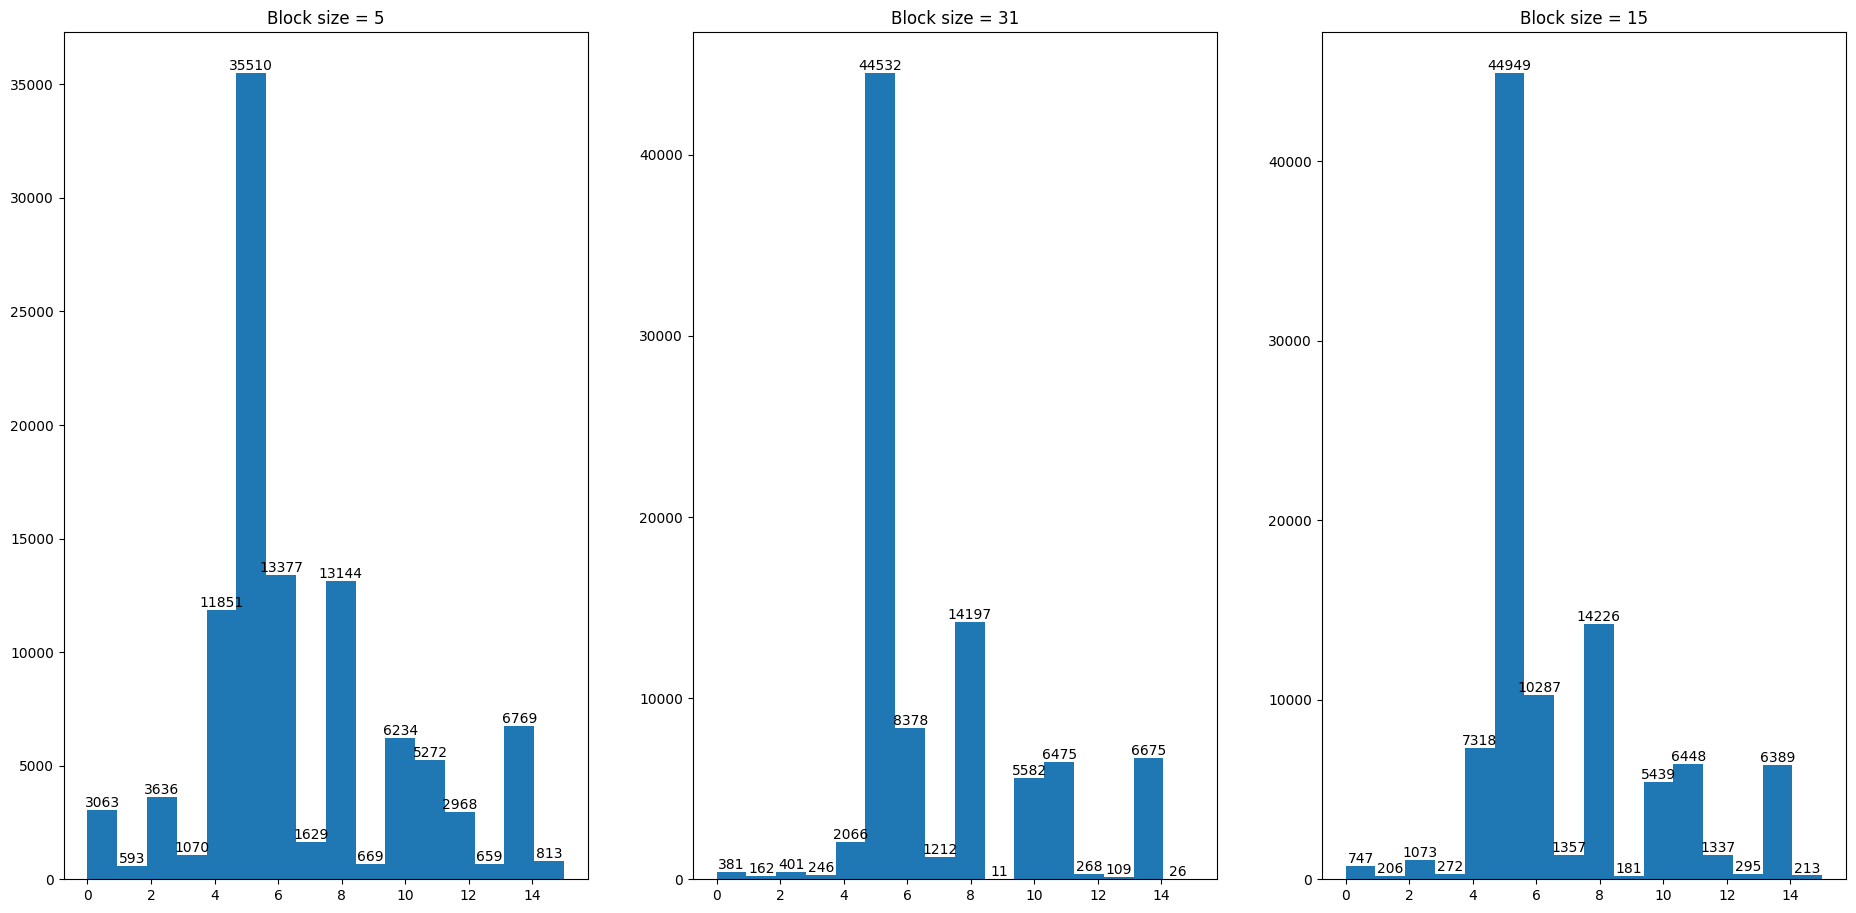

In [13]:
plt.figure(figsize=(23, 11))

plt.subplot(131)
counts, edges, bars = plt.hist(pixels_fro1, bins=len(set(pixels_fro1)))
plt.bar_label(bars)
plt.title("Block size = 5")

plt.subplot(132)
counts, edges, bars = plt.hist(pixels_fro2, bins=len(set(pixels_fro2)))
plt.bar_label(bars)
plt.title("Block size = 31")

plt.subplot(133)
counts, edges, bars = plt.hist(pixels_fro3, bins=len(set(pixels_fro3)))
plt.bar_label(bars)
plt.title("Block size = 15")

plt.show();

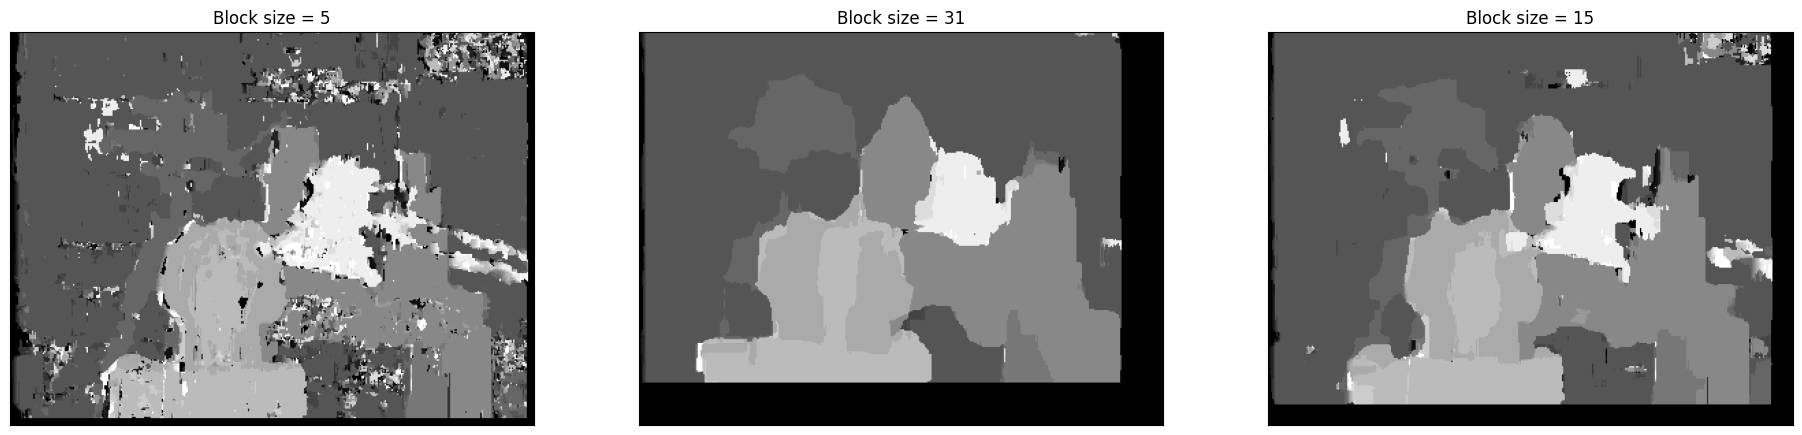

In [14]:
disparity_map_frof1, pixels_frof1 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=5, metric_type="fro"
)
disparity_map_frof2, pixels_frof2 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=31, metric_type="fro"
)
disparity_map_frof3, pixels_frof3 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=15, metric_type="fro"
)

plt.figure(figsize=(23, 11))

plt.subplot(131)
plt.imshow(disparity_map_frof1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 5")

plt.subplot(132)
plt.imshow(disparity_map_frof2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 31")

plt.subplot(133)
plt.imshow(disparity_map_frof3, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 15")

plt.show();

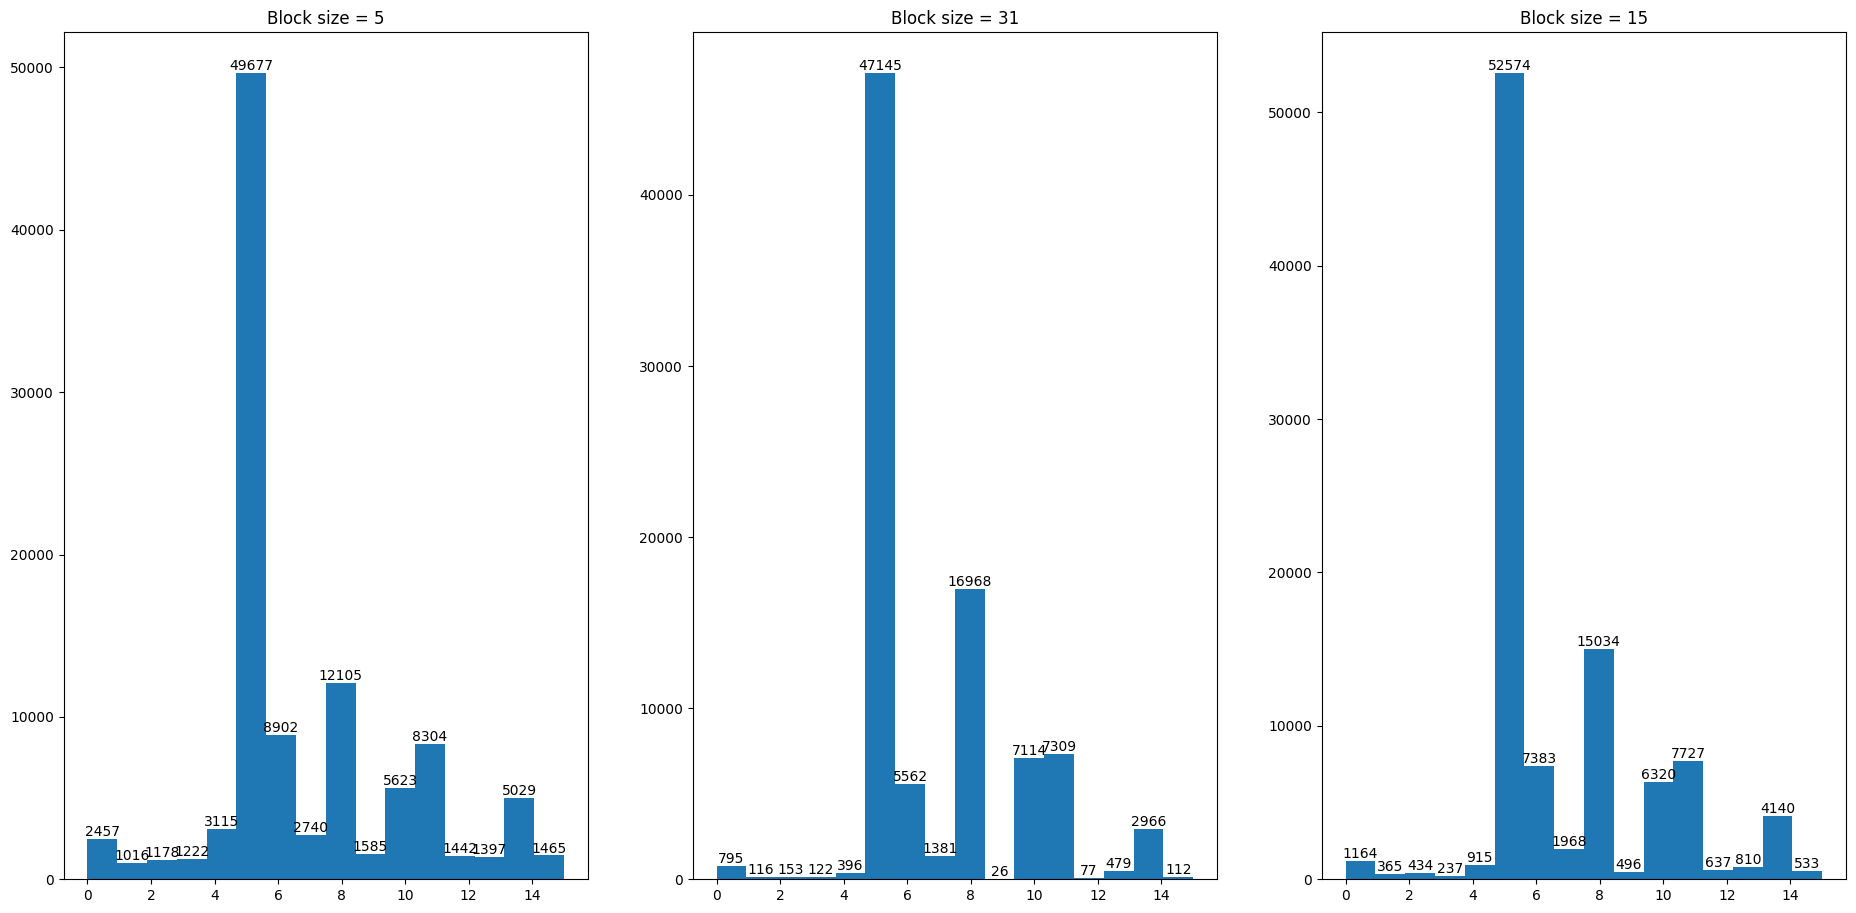

In [15]:
plt.figure(figsize=(23, 11))

plt.subplot(131)
counts, edges, bars = plt.hist(pixels_frof1, bins=len(set(pixels_frof1)))
plt.bar_label(bars)
plt.title("Block size = 5")

plt.subplot(132)
counts, edges, bars = plt.hist(pixels_frof2, bins=len(set(pixels_frof2)))
plt.bar_label(bars)
plt.title("Block size = 31")

plt.subplot(133)
counts, edges, bars = plt.hist(pixels_frof3, bins=len(set(pixels_frof3)))
plt.bar_label(bars)
plt.title("Block size = 15")

plt.show();

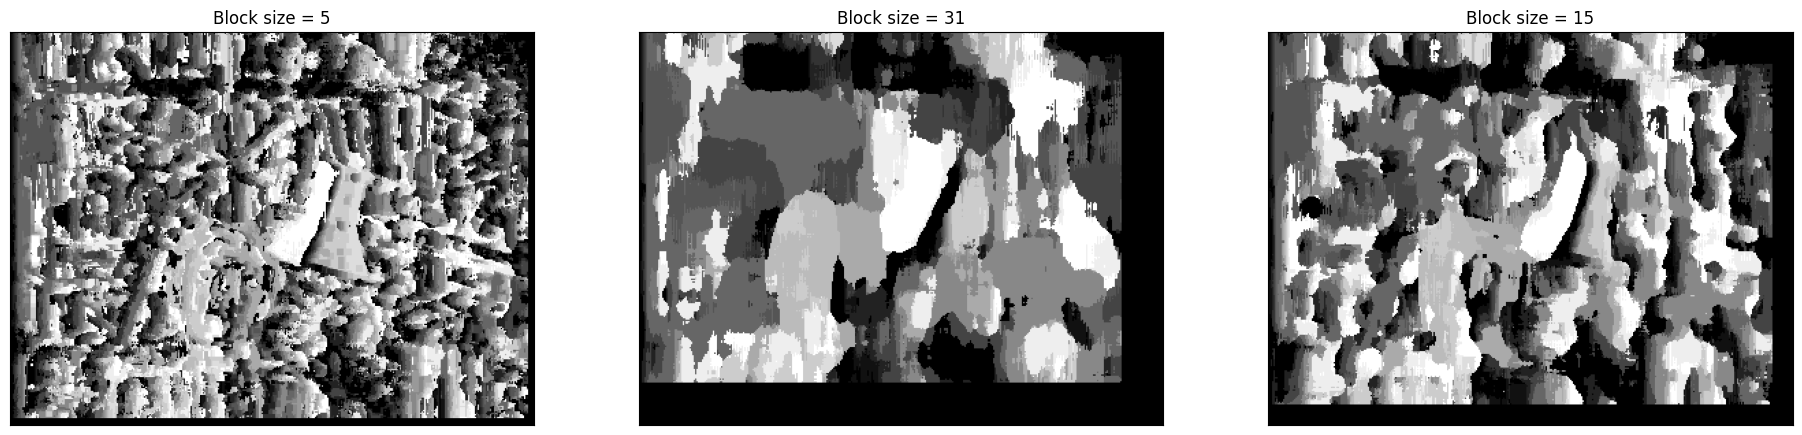

In [16]:
disparity_map_abs1, pixels_abs1 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=5, metric_type="abs"
)
disparity_map_abs2, pixels_abs2 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=31, metric_type="abs"
)
disparity_map_abs3, pixels_abs3 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=15, metric_type="abs"
)

plt.figure(figsize=(23, 11))

plt.subplot(131)
plt.imshow(disparity_map_abs1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 5")

plt.subplot(132)
plt.imshow(disparity_map_abs2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 31")

plt.subplot(133)
plt.imshow(disparity_map_abs3, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 15")

plt.show();

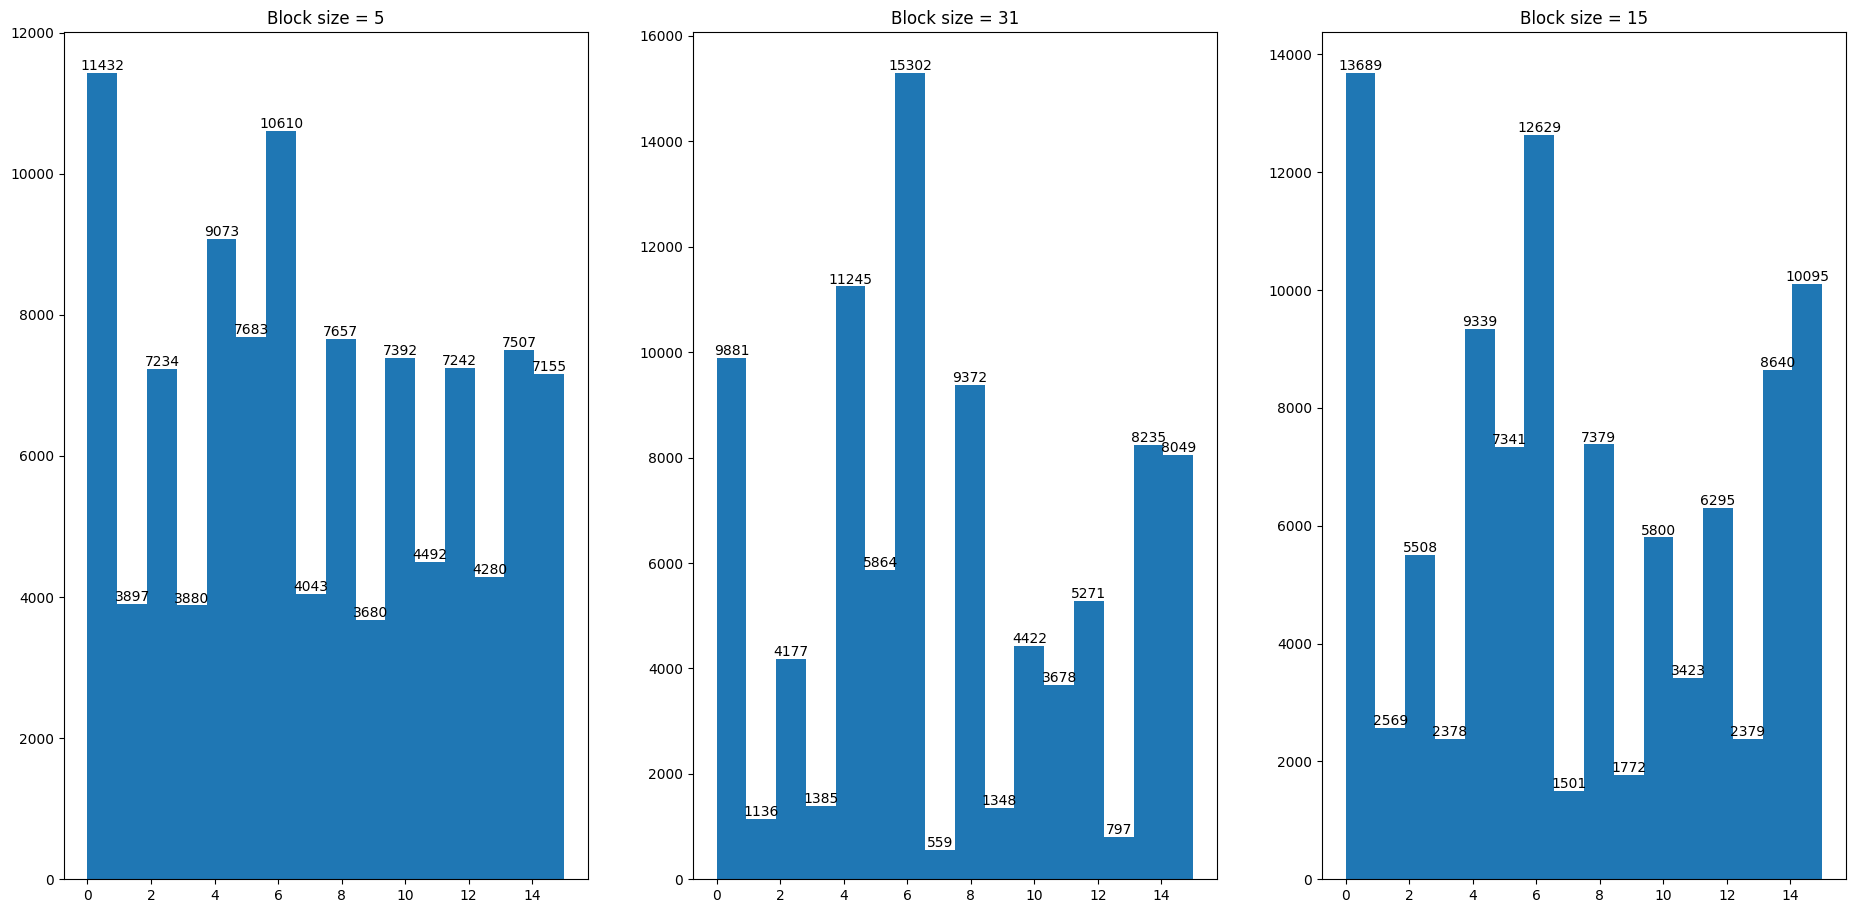

In [17]:
plt.figure(figsize=(23, 11))

plt.subplot(131)
counts, edges, bars = plt.hist(pixels_abs1, bins=len(set(pixels_abs1)))
plt.bar_label(bars)
plt.title("Block size = 5")

plt.subplot(132)
counts, edges, bars = plt.hist(pixels_abs2, bins=len(set(pixels_abs2)))
plt.bar_label(bars)
plt.title("Block size = 31")

plt.subplot(133)
counts, edges, bars = plt.hist(pixels_abs3, bins=len(set(pixels_abs3)))
plt.bar_label(bars)
plt.title("Block size = 15")

plt.show();

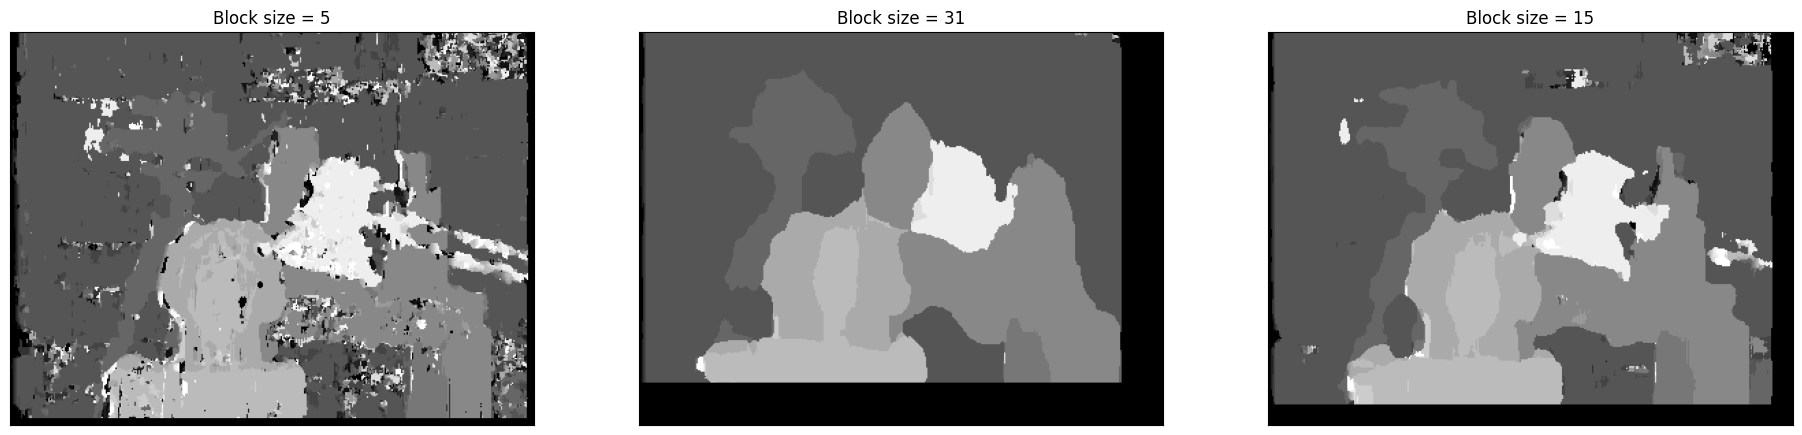

In [18]:
disparity_map_absf1, pixels_absf1 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=5, metric_type="abs"
)
disparity_map_absf2, pixels_absf2 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=31, metric_type="abs"
)
disparity_map_absf3, pixels_absf3 = get_disparity(
    imgL=cv2.Sobel(imgL, cv2.CV_64F, 1, 0), imgR=cv2.Sobel(imgR, cv2.CV_64F, 1, 0),
    numDisparities=16, blockSize=15, metric_type="abs"
)

plt.figure(figsize=(23, 11))

plt.subplot(131)
plt.imshow(disparity_map_absf1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 5")

plt.subplot(132)
plt.imshow(disparity_map_absf2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 31")

plt.subplot(133)
plt.imshow(disparity_map_absf3, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block size = 15")

plt.show();

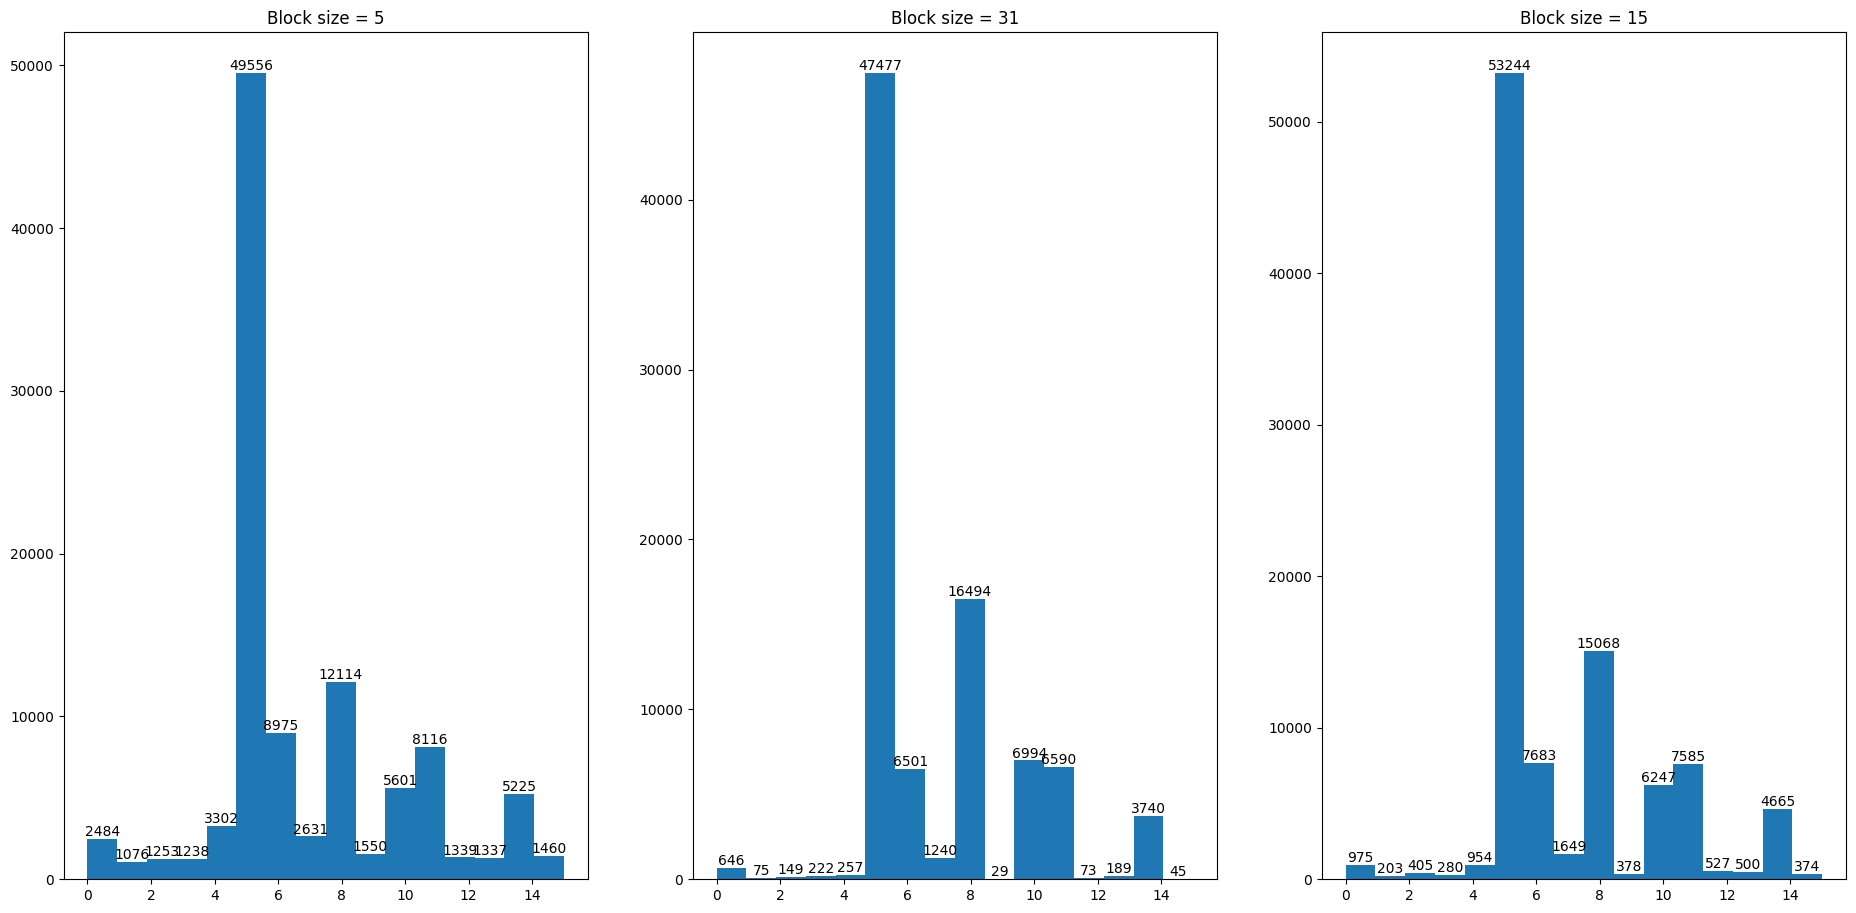

In [19]:
plt.figure(figsize=(23, 11))

plt.subplot(131)
counts, edges, bars = plt.hist(pixels_absf1, bins=len(set(pixels_absf1)))
plt.bar_label(bars)
plt.title("Block size = 5")

plt.subplot(132)
counts, edges, bars = plt.hist(pixels_absf2, bins=len(set(pixels_absf2)))
plt.bar_label(bars)
plt.title("Block size = 31")

plt.subplot(133)
counts, edges, bars = plt.hist(pixels_absf3, bins=len(set(pixels_absf3)))
plt.bar_label(bars)
plt.title("Block size = 15")

plt.show();

Из графиков видно, что в определённой степени заполняются все пиксели глубины. В случае отстутствия фильтров на изображениях норма Фробениуса в качестве метрики более предпочтительна, т.к. она выравнивает значения заполняемых глубин в сторону средних. При $L$-$1$ (SAD) норме распределение издалека напоминает равномерное, а картинка $-$ шумная. Если использовать фильтр Собеля, например, то изображения становятся более приятными на глаз.

## Задание 2

Сравните свою реализацию с opencv StereoBM с помощью попиксельного сравнения карт диспаратности.

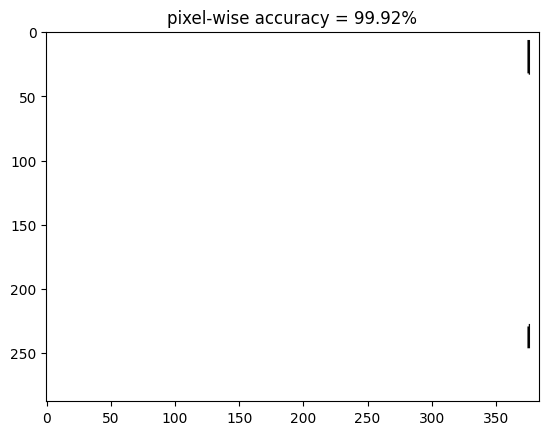

In [20]:
acc = sum(sum(disparity_map_fro3 == disparity)) / sum(sum(np.ones_like(disparity)))
plt.title(f"pixel-wise accuracy = {100*(1 - acc):.5}%")
plt.imshow(disparity_map_fro3 != disparity, cmap='gray')
plt.show();


## Вопрос 3

Как еще с помощью пройденных классических алгоритмов можно построить карту диспаратности? Приведите краткое описание придуманного/существующего алгоритма.

**Ответ:** первое улучшение – изменение метрики (Фробениус, разные абсолютные дистанции, брать `argmin` или обновлять глобальный миниум метрики). SAD показывает себя лучше обычно, так как более устойчива к выбросам, подробный обзор можно найти по [ссылке](https://www.hindawi.com/journals/js/2016/8742920/).

Все реализованные методы можно разделить на глобальные и локальные:
* The best known approaches among the global methods are [belief propagation](https://en.wikipedia.org/wiki/Belief_propagation) (BP) and [graph cut](https://github.com/sjawhar/cv-stereo-disparity-graph-cuts) (GC) algorithms.
* [локальные](https://assets.researchsquare.com/files/rs-2145817/v1_covered.pdf?c=1665675633):
    * WTA — Winner Takes All (Наш)
    * SAD — Sum Of Absolute Differences
    * SSD — Sum Of Square Differences
    * NCC — Normal Cross Correlation
    * ASW — Adaptive support weight
    * SIUDL — Stereo images using deep learning